A/B–тестирование

 В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Задача - необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Входные данные
В качестве входных данных имеем 4 csv-файла, хранящиеся на Яндекс диске:

    1) groups.csv – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
    2) groups_add.csv – дополнительный файл с пользователями, который прислали спустя 2 дня после передачи основных данных
    3) active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
    4) checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента. 


# План работ:
1) Загрузка данных через API
2) Предобработка данных
3) Формирование финального набора данных
4) Анализ полученных данных:
    - выясним какой % платящих клиентов в каждой группе (контрольной и тестовой)- метрика CR;
    - проанализируем среднюю выручку от платящих пользователей в двух группах - метрика ARPPU;
5) Если есть различия и они в пользу тестовой группы, проверим на сколько они статисически значимы
6) Выводы и рекомендации


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
from urllib.parse import urlencode

In [4]:
# Загрузка данных  с Яндекс диска через API плюс проверка, есть ли дополнительный файл с апдейтом.

# Пути к файлам 
file_path_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
file_path_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
file_path_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
file_path_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

def get_public_download_url(public_key: str) -> str:
    api_base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    encoded_params = urlencode({'public_key': public_key})
    full_request_url = api_base_url + encoded_params

    response = requests.get(full_request_url)
    
    download_link = response.json().get('href')
    if not download_link:
        raise ValueError(f"Не удалось получить ссылку для скачивания для ключа: {public_key}")
    return download_link


def update_data(file_path_groups, file_path_groups_add, file_path_active_studs, file_path_checks):
    # Загрузка данных
    df_groups = pd.read_csv(get_public_download_url(file_path_groups), sep=';')
    df_active_studs = pd.read_csv(get_public_download_url(file_path_active_studs), sep=',')
    df_checks = pd.read_csv(get_public_download_url(file_path_checks), sep=';')
    df_groups_add = pd.read_csv(get_public_download_url(file_path_groups_add), sep=',')
    # Возвращаем полученные датафреймы

    
    return df_groups, df_groups_add, df_active_studs, df_checks

In [5]:
df_groups, df_groups_add, df_active_studs, df_checks = update_data(
    file_path_groups, file_path_groups_add, file_path_active_studs, file_path_checks)

In [6]:
df_groups.tail(3)

,id,grp
74481,5692865,B
74482,5693667,B
74483,5694419,B


In [7]:
df_groups.shape

(74484, 2)

In [8]:
df_groups_add.head(3)

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B


In [9]:
df_groups_add.shape

(92, 2)

In [10]:
df_active_studs.head(3)

,student_id
0,581585
1,5723133
2,3276743


In [11]:
df_active_studs.shape

(8341, 1)

In [12]:
df_checks.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [13]:
df_checks.shape

(541, 2)

In [14]:
# Объединение двух таблиц с данными о пользователях  в одну
df_groups_full = pd.concat([df_groups, df_groups_add], ignore_index=True)
df_groups_full.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


2) Препроцессинг. В виду того, что таблицы довольно простые, нет разнообразия форматов данных (даты и т.д.), то и сложной подготовки данных не требуется.

In [16]:
# Таблца с данными о принаджедности пользователей к тестовой или контрольной группе
df_groups_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [17]:
df_groups_full.nunique()

id     74576
grp        2
dtype: int64

In [18]:
df_groups_full.isna().sum()

id     0
grp    0
dtype: int64

In [19]:
# Таблца с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
df_active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [20]:
df_active_studs.nunique()

student_id    8341
dtype: int64

In [21]:
df_active_studs.isna().sum()

student_id    0
dtype: int64

In [22]:
# Таблца с информацией об оплатах пользователей в дни проведения эксперимента
df_checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [23]:
df_checks.nunique()

student_id    541
rev            39
dtype: int64

In [24]:
df_checks.isna().sum()

student_id    0
rev           0
dtype: int64

Предварительный анализ данных показал, что дообработка не требуется, дубликатов нет, пропусков значений нет, конвертация форматов не требуется.

К полученной таблице со всеми пользователями, разделенными на тестовую и контрольную выборки, добавлю колонку со
статусом в зависимости был ли пользователь активен или нет в аналзируемый период времени (на основе данных из таблицы df_active_studs)

In [27]:
df_groups_full['is_active'] = df_groups_full['id'].isin(df_active_studs['student_id'])
df_groups_full.head()

,id,grp,is_active
0,1489,B,False
1,1627,A,True
2,1768,B,False
3,1783,B,False
4,1794,A,False


In [28]:
# Объединю полученную таблицу с информауцией по оплатам в полный финальный датасет
df_checks = df_checks.rename(columns={'student_id': 'id'})
full_df = pd.merge(df_groups_full, df_checks, how='left', on='id')
full_df['rev'] = full_df['rev'].fillna(0) 
full_df.head()

,id,grp,is_active,rev
0,1489,B,False,0.0
1,1627,A,True,990.0
2,1768,B,False,0.0
3,1783,B,False,0.0
4,1794,A,False,0.0


In [29]:
full_df.shape

(74576, 4)

In [30]:
# Делаю резервную копию полного набора данных 
full_df_copy = full_df.copy()

 Следующим шагом оставлю для анализа только активных в исследуемый период пользователей,
 так как даже если были оплаты у неактивных пользователей, предположу, что это автоматические списания за подписку, 
 учитывать их в анализе нецелесообразно.

In [32]:
non_active_paid_df = full_df.query("is_active==False and rev > 0")
non_active_paid_df.shape

(149, 4)

Таким образом, иы нашли 149 пользователей, которые совершили оплату, но не числятся в списке активных пользователей в исследуемом периоде времени, опять же предположу, что это автоматические списания за подписку, 
 учитывать их в анализе нецелесообразно. Поэтому следующим шагом оставлю только активных пользователей.

In [34]:
active_df = full_df.query("is_active==True")
active_df.shape

(8341, 4)

In [35]:
active_df.grp.value_counts(normalize=True).mul(100)

grp
B    81.560964
A    18.439036
Name: proportion, dtype: float64

Получается размер контрольной группы 13,4%
размер тестовой группы - 81,56% 
Что  в целом допустимо, но не есть best practice  при разработке А/В теста.

In [37]:
# Сделаю дополнительную колонку: если пользователь платил, присвоим 1, если нет -0
active_df['rev_binary'] = active_df['rev'].apply(lambda x: 1 if x>0 else 0)

C:\Users\NF\AppData\Local\Temp\ipykernel_17464\1598542903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_df['rev_binary'] = active_df['rev'].apply(lambda x: 1 if x>0 else 0)


In [38]:
active_df.head()

,id,grp,is_active,rev,rev_binary
1,1627,A,True,990.0,1
10,2085,B,True,0.0,0
12,2215,B,True,0.0,0
43,3391,A,True,0.0,0
45,3401,B,True,0.0,0


In [39]:
cross = pd.crosstab(active_df.grp, active_df.rev_binary)
#Вычислю проценты оплативших в каждой группе
cross['total'] = cross.sum(axis=1)
cross['percent'] = (cross[1] / cross['total']) * 100 
cross

rev_binary,0,1,total,percent
grp,,,,
A,1460,78,1538,5.071521
B,6489,314,6803,4.615611


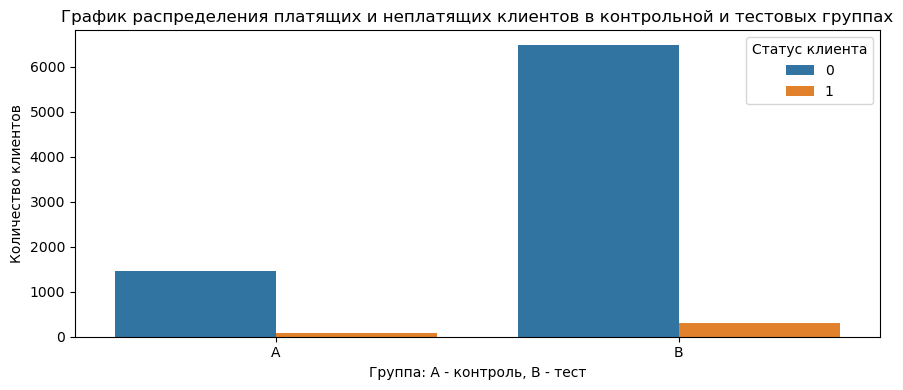

In [40]:
# Взглянем на предварительный график распредения платящих  и неплатящих клиентов в контрольной и тестовых группах
plt.figure(figsize=(9, 4))  
sns.countplot(data=active_df, x='grp', hue='rev_binary')

plt.title('График распределения платящих и неплатящих клиентов в контрольной и тестовых группах')
plt.xlabel('Группа: A - контроль, B - тест')
plt.ylabel('Количество клиентов')
plt.legend(title='Статус клиента')
plt.tight_layout()
plt.show()

    В результате вычисления и анализа полученного графика, мы понимаем, что в контрольной группе А, процент оплативших клиентов неколько выше, чем в тестовой группе В (5,07% против 4,6%), но понять на сколько это статистически значимо или является случайной флуктуацией поможет только стат. тест.
    
    Хотя уже на этом этапе довольно очевидно, что на конверсию в оплату новая система платежей не оказывает никакого положительного эффекта: во-первых, разница в конверсиях даже на этапе сравнения простых пропорций уже не в пользу тестовой группы, а во-вторых, учитывая, что контрольная группа у нас в 5 раз меньше, чем тестовая, и стат.тесты могут ошибиться  в пользу тестовой группы за счет ее  масштаба, но даже этого в нашем случае нет.
 
     Поскольку у нас две категориальные переменные и нам нужно сравнить их частотность, будем использовать Кси-квадрат. 
    Нулевая гипотеза (Н0): разница между тестовой и контрольной группой отсутсвует (наши различия в 0,47% - стат погрешность).
    Альтернативная гипотеза (Н1): различия статистически значимы.

In [42]:
from scipy.stats import chi2_contingency, chi2

In [43]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(active_df.grp, active_df.rev_binary))

In [44]:
stat, p

(0.48480826522557896, 0.48625240457231045)

Для оценки статистической зависимости между группами пользователей (grp) и наличием выручки (rev_binary) был проведён хи-квадрат тест независимости.
Результаты теста:
Хи-квадрат статистика: 0.485
p-value: 0.486

Интерпретация:
Поскольку значение p-value превышает стандартное пороговое значение 0.05, нет оснований отвергнуть нулевую гипотезу.
Это означает, что различия в конверсии в оплату между группами A и B не являются статистически значимыми.

Вывод:
Группа пользователя (grp) и факт наличия выручки (rev_binary) статистически независимы. Следовательно, принадлежность к группе не влияет на вероятность того, что пользователь сгенерирует выручку.

In [46]:
"""" Для анализа метрики ARPPU (сколько в среднем приносили платящие пользователи на человека) для каждой группы 
вернемся к датасету active_df. Эта метрика будет оценивать не потенциальное количество оплат, как CR,
а "качество" клиентов, возможно новая система оплаты будет стимулировать более высокие продажи """
active_df.head()

,id,grp,is_active,rev,rev_binary
1,1627,A,True,990.0,1
10,2085,B,True,0.0,0
12,2215,B,True,0.0,0
43,3391,A,True,0.0,0
45,3401,B,True,0.0,0


C:\Users\NF\AppData\Local\Temp\ipykernel_17464\4042167030.py:16: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



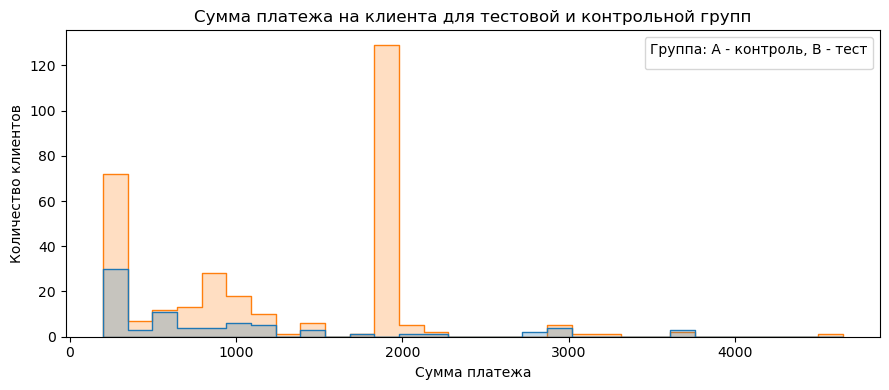

In [106]:
# Посмотрим на график распределения сумм платежей для пользователей, кто был активен и совершил оплату в период эксперимента
plt.figure(figsize=(9, 4))

sns.histplot(
    data=active_df.query("rev > 0"),
    x="rev",
    hue="grp",
    bins=30,
    element="step",  # или "bars" для сплошных столбиков
    stat="count"     # по умолчанию, можно опустить
)

plt.title("Сумма платежа на клиента для тестовой и контрольной групп")
plt.xlabel("Сумма платежа")
plt.ylabel("Количество клиентов")
plt.legend(title="Группа: A - контроль, B - тест")
plt.tight_layout()
plt.show()

In [48]:
#Сохраню в отдельные датафреймы данные по контрольной и тестовой группам, только для платящих клиентов
active_A = active_df.query('grp=="A" and rev > 0')
active_A = active_A['rev']
active_A.shape

(78,)

In [49]:
active_B = active_df.query('grp=="B" and rev > 0')
active_B = active_B['rev']
active_B.shape

(314,)

In [50]:
# Средний чек на платящего активного пользователя в контрольной группе
A_ARPPU = round(active_A.mean(),2)
A_ARPPU

933.59

In [51]:
# # Средний чек на платящего активного пользователя в тестовой группе
B_ARPPU = round(active_B.mean(),2)
B_ARPPU

1257.88

При визуальном анализе распределений для контрольной и тестовой групп, кажется, что новая система оплаты может иметь положительное влияние на на средний чек. Так же средний чек на платящего клиента в тестовой группе существенно выше, чем в контрольной (1257,88 и 933,59 соответственно). Очевидно, что оба распределения не являются нормальными (по характеру распределения на графике это видно).
Поэтому для дальнейшего выбора статистического теста проверим равенство дисперсий тестом Левена.  
Нулевая гипотеза (Н0): разница в дисперсиях распределения среднего чека с одного платящего клиента между тестовой и контрольной группой отсутсвует.
Альтернативная гипотеза (Н1): различия статистически значимы.

In [53]:
from scipy.stats import levene

stat, p = levene(active_A, active_B)
print(f"Levene test statistic: {stat}, p-value: {p}")

Levene test statistic: 3.075681699981606, p-value: 0.08025675761347022


Интерпретация результата:
Так как значение p-value = 0,08, что > 0.05, не отвергаем нулевую гипотезу, таким образом, будем считать дисперсии равными.
Для дальнейшей проверки отличия средних значений чеков на каждого платящего клиента в контрольной и тестовой группах будем использоват t-test.
Нулевая гипотеза (Н0):  Средний чек на платящего активного пользователя в тестовой и контрольной группах равны.
Альтернативная гипотеза (Н1): Средние значения в группах A и B различаются.

In [55]:
from scipy.stats import ttest_ind

stat, p = ttest_ind(active_A, active_B, equal_var=True)
print(f"t-statistic: {stat}, p-value: {p}")

t-statistic: -3.1337795050930985, p-value: 0.001856202526576587


Для оценки статистической разницы в распределниях среднего чека на одного платящего клиента между группами пользователей контрольной и тестовой выборками был проведён  Т-тест.
Результаты теста:
t-statistic = -3.1337795050930985
p-value: 0.0018562025265765867

Интерпретация:
Поскольку p-значение  меньше стандартного уровня значимости (0.05), мы отвергаем нулевую гипотезу.
Это означает, что средние значения в группах A и B различаются статистически значимо.

Вывод:
Средний чек в группе В (тестовая группа) выше среднего чека в контрольной группе А, Т-тест показал, что различия в уровне выручки с каждого платящего клиента статистически значимы. Следовательно, можно говорить о том, что новая система платежей способсвует росту среднего чека.

Выводы:
Конверсия в оплату между группами A и B не различается ( и p-value = 0.486). То есть доля пользователей, совершающих покупки, осталась прежней.

Средний чек на одного платящего пользователя в группе B значительно выше (и p-value = 0.001856). Это значит, что платящие пользователи тратят больше при новой системе платежей.

Итоговый вывод:
Хотя новая система оплаты не влияет на саму вероятность того, что пользователь совершит оплату, она значительно увеличивает сумму оплаты у тех, кто уже платит. Это говорит о статистически значимом росте среднего чека.

Рекомендация:
Да, имеет смысл внедрить новую систему оплаты для всех пользователей после дополнительного анализа трудозатрат и потенциальной выгоды от нововведения, так как: она не ухудшает конверсию в платёж и при этом увеличивает выручку с каждого платящего клиента.
Это может привести к общему увеличению выручки даже при том же уровне конверсии.